Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.72960541 0.        ]
 [0.         0.57609078]]
la dimenssion de cette matrice est: (100,)


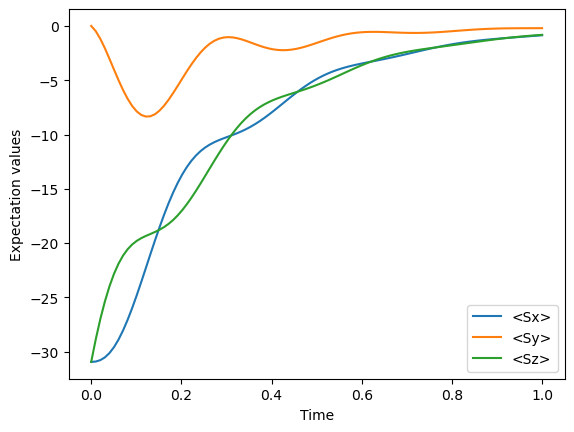

mean square error: 0.029247693111048936


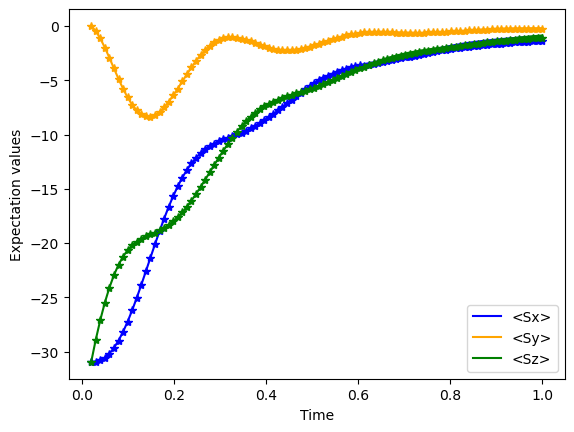

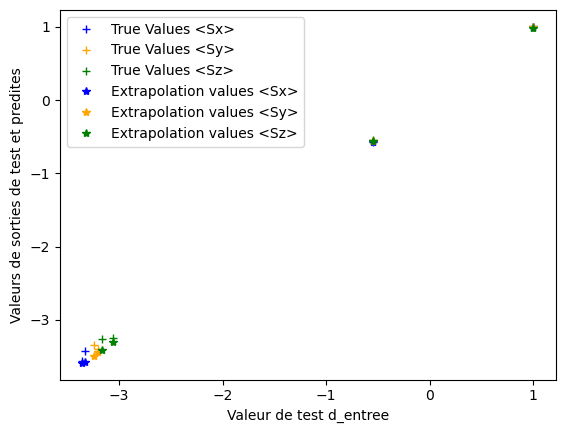

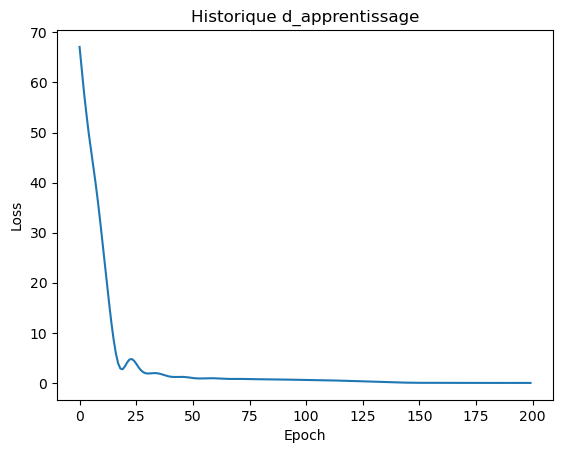

In [73]:
import numpy as np
from qutip import *
# Définition des paramétrés du systeme
N = 7 # Nombre de spin
Omega = 1 # Champ magnétique externe
gamma = 0.5 # Taux de decohérence
beta = 0.1 #Température du bain
# Définition des opérateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1 + sigmaz())
id_ = tensor([qeye(2)]*(N-1))
# Définition des opérateurs de spin
sx_list = [tensor(id_, sx)]*N
sx_S = [tensor(sx, id_)]
sy_list = [tensor(id_, sy)]*N
sy_S = [tensor(sy, id_)]
sz_list = [tensor(id_, sz)]*N
sz_S = [tensor(sz, id_)]
n_list = [tensor(id_, n)]*N
n_S = [tensor(n, id_)]

# Définition du Hamiltonien
def H1D_CBC(omega, V, V_, delta):
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
    #Hamiltonien du systeme
    H_S = omega*sx_S[0] - delta*n_S[0] + V_*(n_S[0])*(n_list[0] + n_list[1])
    H = H_S + H_B
    return(H)

def H_bain(omega, V, delta):
    id_B = tensor([qeye(2)]*(N-2))
    sx_list = [tensor(id_B, sx)]*N
    sy_list = [tensor(id_B, sy)]*N
    sz_list = [tensor(id_B, sz)]*N
    n_list = [tensor(id_B, n)]*N
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        if i ==  0:
            pass
        else:
            H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
   
    return(H_B)

omega = 1
V = 10
V_ = 1
delta = 8
H = H1D_CBC(omega, V, V_, delta)
H_B = H_bain(omega, V, delta)
#print(H)

# Etat initial du systeme
hro0_S = Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]])
# Etat initial du bain
#hro_B = Qobj.expm(-beta*H_B)
hro_B = (-beta*H_B).expm()
#hro0 = tensor(hro0_S, qeye(2**(N-1)))

hro0 = tensor(hro0_S, hro_B)
print('Etat initial:',hro0_S)

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))

# Liste des tems
tlist = np.linspace(0.0, 1.0, 100)

# Evaluation des valeurs a travert la fonction mesolve
result = mesolve(H, hro0, tlist, L, [sx_list[0], sy_list[0], sz_list[0]],
                 args=None, options=None, progress_bar=None, _safe_mode=True)

# Valeurs moyennes des operateurs de spins
msx = result.expect[0]
msy = result.expect[1]
msz = result.expect[2]

# Dimenssion des valeurs moyennes
msx = result.expect[0]
dim = msx.shape
print("la dimenssion de cette matrice est:", dim)


fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0], label='<Sx>')
ax.plot(result.times, result.expect[1], label='<Sy>')
ax.plot(result.times, result.expect[2], label='<Sz>')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
plt.legend()
plt.show()

# MODELE DE PERCEPTRON MULTICOUCHE

# Importation des modules
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Generation des donnees d'apprentissage du MLP

# Donnees d'entrees
tlistx = np.linspace(0, 1, 100)
resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],
                  args=None, options=None, progress_bar=None, _safe_mode=True)
X0 = resultx.expect[0]
X1 = resultx.expect[1] 
X2 = resultx.expect[2]
#print(X0.shape)
# Donnees de sortie
tlisty = np.linspace(0+0.02, 1, 100)
resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]],
                  args=None, options=None, progress_bar=None, _safe_mode=True)
Y0 = resulty.expect[0]
Y1 = resulty.expect[1]
Y2 = resulty.expect[2]
#print(Y0.shape)
#print(X0,X1,X2)

####
#print(X1[2])
#print(Y1[2])
####
X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relles

#Verrification des dimmenssions
#print(X.shape)
#print(Y.shape)


#Division de l'ensemble des donnees en donnees de formation et en donnees de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)
#print(X_train.shape)
#print(Y_train.shape)
#print(X_test.shape)
#print(X_test.shape)


# Architechture neuronale du perceptron multicouche
model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

#Apprentissage du modele avec l'ensemble des donnees d'apprentissage
model.fit(X_train, Y_train)

#Evaluation de la performence du modele avec l'ensemble des donnees de test
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print('mean square error:', mse)
#print(Y_pred.shape)

#Valeux predicte pour chaque observable du systeme
Y_pred_X = Y_pred[:,1]
Y_pred_Y = Y_pred[:,2]
Y_pred_Z = Y_pred[:,3]
#print(Y_pred_X.shape)   #Verrification de la dimmenssion des valeurs predites pour le premier observable de spin

#Visualisation graphique des valeurs compratives
fig, ax = plt.subplots()
#Dynamique exacte
ax.plot(resulty.times, resulty.expect[0], label='<Sx>', color='blue')
ax.plot(resulty.times, resulty.expect[1], label='<Sy>', color='orange')
ax.plot(resulty.times, resulty.expect[2], label='<Sz>', color='green')
#Apprentissage
ax.plot(resulty.times[0:60], Y_train[:,1], linestyle='None', color='blue', marker='*')
ax.plot(resulty.times[0:60], Y_train[:,2], linestyle='None', color='orange', marker='*')
ax.plot(resulty.times[0:60], Y_train[:,3], linestyle='None', color='green', marker='*')
#Extrapolation ou prediction
ax.plot(resulty.times[60:100], Y_pred_X, linestyle='None', color='blue', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Y, linestyle='None', color='orange', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Z, linestyle='None', color='green',marker='*')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
plt.legend()
plt.show()


###
fig, ax=plt.subplots()
ax.plot(X_test[1], Y_test[1], linestyle='None', label='True Values <Sx>', color='blue', marker='+')
ax.plot(X_test[2], Y_test[2], linestyle='None', label='True Values <Sy>', color='orange', marker='+')
ax.plot(X_test[3], Y_test[3], linestyle='None', label='True Values <Sz>', color='green', marker='+')
ax.plot(X_test[1], Y_pred[1], linestyle='None', label ='Extrapolation values <Sx>', color='blue', marker='*')
ax.plot(X_test[2], Y_pred[2], linestyle='None', label ='Extrapolation values <Sy>', color='orange', marker='*')
ax.plot(X_test[3], Y_pred[3], linestyle='None', label ='Extrapolation values <Sz>', color='green', marker='*')
ax.set_xlabel('Valeur de test d_entree')
ax.set_ylabel('Valeurs de sorties de test et predites')
plt.legend()
plt.show()

#Tracer l'Historique d'apprentissage
plt.plot(model.loss_curve_)
plt.title('Historique d_apprentissage')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [66]:
import numpy as np
from qutip import *
# Définition des paramétrés du systeme
N = 7 # Nombre de spin
Omega = 1 # Champ magnétique externe
gamma = 0.5 # Taux de decohérence
beta = 0.1 #Température du bain
# Définition des opérateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1 + sigmaz())
id_ = tensor([qeye(2)]*(N-1))
# Définition des opérateurs de spin
sx_list = [tensor(id_, sx)]*N
sx_S = [tensor(sx, id_)]
sy_list = [tensor(id_, sy)]*N
sy_S = [tensor(sy, id_)]
sz_list = [tensor(id_, sz)]*N
sz_S = [tensor(sz, id_)]
n_list = [tensor(id_, n)]*N
n_S = [tensor(n, id_)]

# Définition du Hamiltonien
def H1D_CBC(omega, V, V_, delta):
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
    #Hamiltonien du systeme
    H_S = omega*sx_S[0] - delta*n_S[0] + V_*(n_S[0])*(n_list[0] + n_list[1])
    H = H_S + H_B
    return(H)

def H_bain(omega, V, delta):
    id_B = tensor([qeye(2)]*(N-2))
    sx_list = [tensor(id_B, sx)]*N
    sy_list = [tensor(id_B, sy)]*N
    sz_list = [tensor(id_B, sz)]*N
    n_list = [tensor(id_B, n)]*N
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        if i ==  0:
            pass
        else:
            H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
   
    return(H_B)

omega = 1
V = 10
V_ = 0.4
delta = 8
H = H1D_CBC(omega, V, V_, delta)
H_B = H_bain(omega, V, delta)
#print(H)

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))
hro0_S = Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]])
 
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error    
    

    
beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []
# Etat initial du systeme
for beta in beta_list:
    #hro_B = Qobj.expm(-beta*H_B)
    hro_B = (-beta*H_B).expm()
    #hro0 = tensor(hro0_S, qeye(2**(N-1)))

    hro0 = tensor(hro0_S, hro_B)
    #print('Etat initial:',hro0_S)

    # Donnees d'entrees
    tlistx = np.linspace(0, 1, 100)
    resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)
    X0 = resultx.expect[0]
    X1 = resultx.expect[1] 
    X2 = resultx.expect[2]

    # Donnees de sortie
    tlisty = np.linspace(0+0.02, 1, 100)
    resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
    Y0 = resulty.expect[0]
    Y1 = resulty.expect[1]
    Y2 = resulty.expect[2]

    X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
    Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relle

    #Division de l'ensemble des donnees en donnees de formation et en donnees de test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

    # Architechture neuronale du perceptron multicouche
    model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

    #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
    model.fit(X_train, Y_train)

    #Evaluation de la performence du modele avec l'ensemble des donnees de test
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mse_list.append(mse)
    mae_list.append(mae)
    print('mean square error:', mse)
    print('mean absolute error:', mae)

mean square error: 0.0024343097523327846
mean absolute error: 0.04630547657495126
mean square error: 0.042937021311844556
mean absolute error: 0.1772457909201598
mean square error: 0.11665863839735076
mean absolute error: 0.27797178325189154


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean square error: 0.0525889079191633
mean absolute error: 0.18424952693953467
mean square error: 0.25108309016457847
mean absolute error: 0.3877816951688067
mean square error: 0.2809398999705994
mean absolute error: 0.37233955543527253


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean square error: 0.17234744257678955
mean absolute error: 0.34903271533374813


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean square error: 0.2529723626246048
mean absolute error: 0.4627518706487994
mean square error: 0.325121096459521
mean absolute error: 0.4647642800423707


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean square error: 0.20325514558318233
mean absolute error: 0.3295220967329544
mean square error: 3.3032823466520203
mean absolute error: 1.261013600055302
mean square error: 2.925678358721861
mean absolute error: 1.458248902292247
mean square error: 3.208143265441273
mean absolute error: 1.3631220619007585


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean square error: 0.6593540891749338
mean absolute error: 0.6942184055712723
mean square error: 0.7079513429218232
mean absolute error: 0.6959006985574139


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [67]:
x= beta_list
y1 = mae_list

In [68]:
import numpy as np
from qutip import *
# Définition des paramétrés du systeme
N = 7 # Nombre de spin
Omega = 1 # Champ magnétique externe
gamma = 0.5 # Taux de decohérence
beta = 0.1 #Température du bain
# Définition des opérateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1 + sigmaz())
id_ = tensor([qeye(2)]*(N-1))
# Définition des opérateurs de spin
sx_list = [tensor(id_, sx)]*N
sx_S = [tensor(sx, id_)]
sy_list = [tensor(id_, sy)]*N
sy_S = [tensor(sy, id_)]
sz_list = [tensor(id_, sz)]*N
sz_S = [tensor(sz, id_)]
n_list = [tensor(id_, n)]*N
n_S = [tensor(n, id_)]

# Définition du Hamiltonien
def H1D_CBC(omega, V, V_, delta):
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
    #Hamiltonien du systeme
    H_S = omega*sx_S[0] - delta*n_S[0] + V_*(n_S[0])*(n_list[0] + n_list[1])
    H = H_S + H_B
    return(H)

def H_bain(omega, V, delta):
    id_B = tensor([qeye(2)]*(N-2))
    sx_list = [tensor(id_B, sx)]*N
    sy_list = [tensor(id_B, sy)]*N
    sz_list = [tensor(id_B, sz)]*N
    n_list = [tensor(id_B, n)]*N
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        if i ==  0:
            pass
        else:
            H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
   
    return(H_B)

omega = 1
V = 10
V_ = 2
delta = 8
H = H1D_CBC(omega, V, V_, delta)
H_B = H_bain(omega, V, delta)
#print(H)

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))
hro0_S = Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]])
 
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error    
    

    
beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []
# Etat initial du systeme
for beta in beta_list:
    #hro_B = Qobj.expm(-beta*H_B)
    hro_B = (-beta*H_B).expm()
    #hro0 = tensor(hro0_S, qeye(2**(N-1)))

    hro0 = tensor(hro0_S, hro_B)
    #print('Etat initial:',hro0_S)

    # Donnees d'entrees
    tlistx = np.linspace(0, 1, 100)
    resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)
    X0 = resultx.expect[0]
    X1 = resultx.expect[1] 
    X2 = resultx.expect[2]

    # Donnees de sortie
    tlisty = np.linspace(0+0.02, 1, 100)
    resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
    Y0 = resulty.expect[0]
    Y1 = resulty.expect[1]
    Y2 = resulty.expect[2]

    X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
    Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relle

    #Division de l'ensemble des donnees en donnees de formation et en donnees de test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

    # Architechture neuronale du perceptron multicouche
    model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

    #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
    model.fit(X_train, Y_train)

    #Evaluation de la performence du modele avec l'ensemble des donnees de test
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mse_list.append(mse)
    mae_list.append(mae)
    #print('mean square error:', mse)
    print('mean absolute error:', mae)

mean absolute error: 0.008300363980180905
mean absolute error: 0.33726277736394705


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.18709487244585926
mean absolute error: 0.4190795108370581
mean absolute error: 0.47809594335379424
mean absolute error: 0.36029858593902797


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4064384483743392


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4493152925986678
mean absolute error: 0.37349654757467077
mean absolute error: 0.7908993086117827


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6333932057428465
mean absolute error: 1.777094420262109
mean absolute error: 2.2755520253835493


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.0669938587822339
mean absolute error: 1.3460314361209884


In [69]:
y2 = mae_list

In [70]:
import numpy as np
from qutip import *
# Définition des paramétrés du systeme
N = 7 # Nombre de spin
Omega = 1 # Champ magnétique externe
gamma = 0.5 # Taux de decohérence
beta = 0.1 #Température du bain
# Définition des opérateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1 + sigmaz())
id_ = tensor([qeye(2)]*(N-1))
# Définition des opérateurs de spin
sx_list = [tensor(id_, sx)]*N
sx_S = [tensor(sx, id_)]
sy_list = [tensor(id_, sy)]*N
sy_S = [tensor(sy, id_)]
sz_list = [tensor(id_, sz)]*N
sz_S = [tensor(sz, id_)]
n_list = [tensor(id_, n)]*N
n_S = [tensor(n, id_)]

# Définition du Hamiltonien
def H1D_CBC(omega, V, V_, delta):
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
    #Hamiltonien du systeme
    H_S = omega*sx_S[0] - delta*n_S[0] + V_*(n_S[0])*(n_list[0] + n_list[1])
    H = H_S + H_B
    return(H)

def H_bain(omega, V, delta):
    id_B = tensor([qeye(2)]*(N-2))
    sx_list = [tensor(id_B, sx)]*N
    sy_list = [tensor(id_B, sy)]*N
    sz_list = [tensor(id_B, sz)]*N
    n_list = [tensor(id_B, n)]*N
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        if i ==  0:
            pass
        else:
            H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
   
    return(H_B)

omega = 1
V = 10
V_ = 8
delta = 8
H = H1D_CBC(omega, V, V_, delta)
H_B = H_bain(omega, V, delta)
#print(H)

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))
hro0_S = Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]])
 
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error    
    

    
beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []
# Etat initial du systeme
for beta in beta_list:
    #hro_B = Qobj.expm(-beta*H_B)
    hro_B = (-beta*H_B).expm()
    #hro0 = tensor(hro0_S, qeye(2**(N-1)))

    hro0 = tensor(hro0_S, hro_B)
    #print('Etat initial:',hro0_S)

    # Donnees d'entrees
    tlistx = np.linspace(0, 1, 100)
    resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)
    X0 = resultx.expect[0]
    X1 = resultx.expect[1] 
    X2 = resultx.expect[2]

    # Donnees de sortie
    tlisty = np.linspace(0+0.02, 1, 100)
    resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
    Y0 = resulty.expect[0]
    Y1 = resulty.expect[1]
    Y2 = resulty.expect[2]

    X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
    Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relle

    #Division de l'ensemble des donnees en donnees de formation et en donnees de test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

    # Architechture neuronale du perceptron multicouche
    model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

    #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
    model.fit(X_train, Y_train)

    #Evaluation de la performence du modele avec l'ensemble des donnees de test
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mse_list.append(mse)
    mae_list.append(mae)
    #print('mean square error:', mse)
    print('mean absolute error:', mae)

mean absolute error: 0.02210496377101162
mean absolute error: 0.2154549913454809
mean absolute error: 0.13984153219847067
mean absolute error: 0.185483254535308
mean absolute error: 0.15870598137855296


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.15556281111413886


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1386418132357492


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.355285543097573


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.27959768217748765


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2673961164736617


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5566675220752827


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5536331536048206


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6631506148495457


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9335381080608132
mean absolute error: 0.9044910672899986


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [71]:
y3 = mae_list

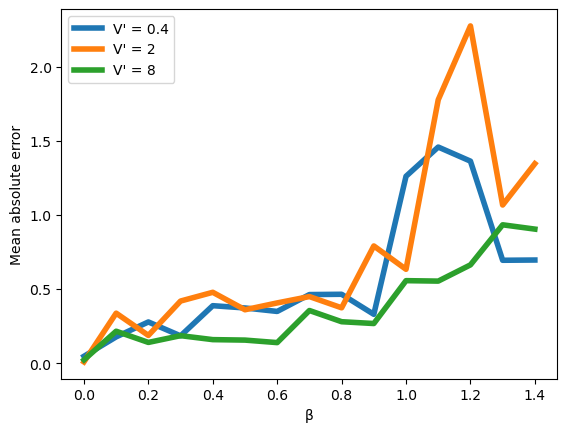

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, y1, label= "V' = 0.4" , linewidth=4)
ax.plot(x, y2, label="V' = 2", linewidth=4)
ax.plot(x, y3, label="V' = 8", linewidth=4)
ax.set_xlabel('β')
ax.set_ylabel('Mean absolute error')
#ax.grid(True)
plt.legend()
plt.show()

In [63]:
import numpy as np
from qutip import *
# Définition des paramétrés du systeme
N = 7 # Nombre de spin
Omega = 1 # Champ magnétique externe
gamma = 0.5 # Taux de decohérence
beta = 0.1 #Température du bain
# Définition des opérateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1 + sigmaz())
id_ = tensor([qeye(2)]*(N-1))
# Définition des opérateurs de spin
sx_list = [tensor(id_, sx)]*N
sx_S = [tensor(sx, id_)]
sy_list = [tensor(id_, sy)]*N
sy_S = [tensor(sy, id_)]
sz_list = [tensor(id_, sz)]*N
sz_S = [tensor(sz, id_)]
n_list = [tensor(id_, n)]*N
n_S = [tensor(n, id_)]

# Définition du Hamiltonien
def H1D_CBC(omega, V, V_, delta):
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
    #Hamiltonien du systeme
    H_S = omega*sx_S[0] - delta*n_S[0] + V_*(n_S[0])*(n_list[0] + n_list[1])
    H = H_S + H_B
    return(H)

def H_bain(omega, V, delta):
    id_B = tensor([qeye(2)]*(N-2))
    sx_list = [tensor(id_B, sx)]*N
    sy_list = [tensor(id_B, sy)]*N
    sz_list = [tensor(id_B, sz)]*N
    n_list = [tensor(id_B, n)]*N
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        if i ==  0:
            pass
        else:
            H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
   
    return(H_B)

omega = 1
V = 10
V_ = 8
delta = 8
#print(H)

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))
hro0_S = Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]])
 
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error    
    

    
beta_list = np.arange(0, 1.5, 0.1)
V_list = np.arange(0, 8, 0.5)
mse_list = []
mae_list = []
# Etat initial du systeme
for beta in beta_list:
    for V_ in V_list:
        H = H1D_CBC(omega, V, V_, delta)
        H_B = H_bain(omega, V, delta)
        #hro_B = Qobj.expm(-beta*H_B)
        hro_B = (-beta*H_B).expm()
        #hro0 = tensor(hro0_S, qeye(2**(N-1)))

        hro0 = tensor(hro0_S, hro_B)
        #print('Etat initial:',hro0_S)

        # Donnees d'entrees
        tlistx = np.linspace(0, 1, 100)
        resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)
        X0 = resultx.expect[0]
        X1 = resultx.expect[1] 
        X2 = resultx.expect[2]

        # Donnees de sortie
        tlisty = np.linspace(0+0.02, 1, 100)
        resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relle

        #Division de l'ensemble des donnees en donnees de formation et en donnees de test
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
        #print('mean square error:', mse)
        print('mean absolute error:', mae)

mean absolute error: 0.024554143326498558
mean absolute error: 0.009720159623496656
mean absolute error: 0.0248952439463467
mean absolute error: 0.019572147364151332
mean absolute error: 0.03464615421454829
mean absolute error: 0.05455847845970146
mean absolute error: 0.07464422993834756
mean absolute error: 0.0916962273139662
mean absolute error: 0.12741790246192278
mean absolute error: 0.13097769250367935
mean absolute error: 0.14125748637149266
mean absolute error: 0.16069848695942204
mean absolute error: 0.08796391909854993
mean absolute error: 0.0828518237528985
mean absolute error: 0.0748595748138253
mean absolute error: 0.03424619045329627
mean absolute error: 0.10882289916209388
mean absolute error: 0.13847609741279449


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1438808629875172
mean absolute error: 0.12138586470250204
mean absolute error: 0.3127973934155359
mean absolute error: 0.20234229408528803
mean absolute error: 0.12080517314067724
mean absolute error: 0.1736601573574273
mean absolute error: 0.17274337713064888
mean absolute error: 0.15598804758920237
mean absolute error: 0.26230391428704414
mean absolute error: 0.20573943978755022
mean absolute error: 0.18004808299743708
mean absolute error: 0.188606781107294
mean absolute error: 0.20474545238726086
mean absolute error: 0.5643230748854176
mean absolute error: 0.48168205394909835
mean absolute error: 0.2898165466423916
mean absolute error: 0.3364844524975295
mean absolute error: 0.33731482080661557


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.12907780510046174
mean absolute error: 0.3172324292197386
mean absolute error: 0.5684861802807969
mean absolute error: 0.481677315339263


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.175381095227768


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.17364641690505517
mean absolute error: 0.4425118449771719


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.11185400629701397


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1948884508957195


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.15268526335229782


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.14720944008534842


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.11763364321228609
mean absolute error: 0.5756265553475034
mean absolute error: 0.48425645767208203
mean absolute error: 0.3678589228312729


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2908200608486906
mean absolute error: 0.20807854161013042


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.21523472360166307
mean absolute error: 0.47048997184405184
mean absolute error: 0.22160375170778956
mean absolute error: 0.3332488559175811


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.26766602303443193


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.19562834815434685
mean absolute error: 0.30593525465788285


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1760951269523605


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2633992951318018
mean absolute error: 0.5463539188768193


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1477880522488405


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.28097113292043824
mean absolute error: 0.41672894634904756
mean absolute error: 0.4137467114993607
mean absolute error: 0.4144645191957201
mean absolute error: 0.45011015377279545


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3682174330714093
mean absolute error: 0.46209602178450865
mean absolute error: 0.5814816973492387
mean absolute error: 0.5718016066209262
mean absolute error: 0.3007830133370868
mean absolute error: 0.4552508616144589
mean absolute error: 0.46210848476711774


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2097740449438706


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.24464470117544668


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2137303124227034


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1790409146460219


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2647175584738006
mean absolute error: 0.4949142633438752
mean absolute error: 0.5116297486429299
mean absolute error: 0.5341188794993772
mean absolute error: 0.4789357405183522


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2626022551603031


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.28215906007119596
mean absolute error: 0.477368292678396
mean absolute error: 0.6356401795564419
mean absolute error: 0.5528337795633324


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3279516400957283


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.37762316608900237


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3320813313504166


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.28904974567160724


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.29748837014678453
mean absolute error: 0.5390211543113591
mean absolute error: 1.0445556805595655


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.28847654891938884


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.48605183763368803
mean absolute error: 0.5293350864815041
mean absolute error: 0.47105488305004284
mean absolute error: 0.5454372330338775
mean absolute error: 0.42364810262377717
mean absolute error: 0.6449875498340149
mean absolute error: 0.6704967108212856
mean absolute error: 0.5080868988981198
mean absolute error: 0.719571681145176
mean absolute error: 0.5366030731205217
mean absolute error: 0.6640820186017868


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3814857062621829
mean absolute error: 0.6476039712499808


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4477389809268718
mean absolute error: 0.4837859279914858


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3711546648700793
mean absolute error: 0.7308385652131734
mean absolute error: 0.8487972949204388
mean absolute error: 0.8056642979994191
mean absolute error: 0.6743465237239425
mean absolute error: 0.6593583434748352


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.40705381549342634
mean absolute error: 0.7870559409687334


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.43539513785258277


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.35689840519215915
mean absolute error: 0.8154361338900836


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.36787628351383506


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4411165568905827
mean absolute error: 0.4971685910016347
mean absolute error: 0.6188758680473063


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.39863871633852577
mean absolute error: 0.9293585076028279
mean absolute error: 0.7275605487439758
mean absolute error: 0.8058222416887884


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6387653876231033


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6964314789529138
mean absolute error: 1.1547240322808885
mean absolute error: 0.4427293813342242
mean absolute error: 0.9747065783647242
mean absolute error: 0.46965301704932283


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.38787833458544707
mean absolute error: 0.8552899741825126


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.44845731408624484
mean absolute error: 0.6324067021798746
mean absolute error: 0.6326155027852093


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6870054966246018
mean absolute error: 1.1582933549967138
mean absolute error: 0.5517431196761251
mean absolute error: 1.0743553725561992
mean absolute error: 0.5181113808817286
mean absolute error: 0.8119393517975455
mean absolute error: 1.013903581882041
mean absolute error: 1.2020023805241051


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5815800185236387


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5120722315897981
mean absolute error: 0.4375239265039478


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5023153342495226
mean absolute error: 0.5680091621808949
mean absolute error: 0.9293717793614282


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5247734035448496
mean absolute error: 1.3743625302135987


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6761944484325482
mean absolute error: 2.2824743383081776


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6572305122388865


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6431076468163399


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6527424604080647


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6356089265118272
mean absolute error: 1.833737827887579
mean absolute error: 1.1688440252553272
mean absolute error: 1.346440472850893
mean absolute error: 1.302206904594318


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6383129860782041
mean absolute error: 1.7131146932672001
mean absolute error: 1.2996453064513536
mean absolute error: 1.4234858756542672


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7211567367898102


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7418215637865844
mean absolute error: 0.9176236650683981
mean absolute error: 2.5567790610106784
mean absolute error: 1.7648166875469382


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7505653558993223
mean absolute error: 1.8138802491462773


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6459041508716951
mean absolute error: 1.1850874780177545
mean absolute error: 1.2896798862085066


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8420984175328173


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6769899210264951


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.860824950785289
mean absolute error: 1.8616912950112035


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7185057075089588
mean absolute error: 1.8363729395380204
mean absolute error: 1.6013665699338604
mean absolute error: 0.9173241967016419


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.027773584845682


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2516679158013753
mean absolute error: 2.2821351212358794


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9576478722851807


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.945107896711556
mean absolute error: 1.5580205470859898
mean absolute error: 0.8093784640431381
mean absolute error: 2.0961465312120326


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7976288862105622
mean absolute error: 2.5295064988876392
mean absolute error: 0.8464254856292931
mean absolute error: 0.8484275654965084


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8782708541969733
mean absolute error: 0.9600559059317022
mean absolute error: 2.3196173059406426


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1906377320203683
mean absolute error: 3.0178073633849642
mean absolute error: 3.442347733939052


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4692247851297182


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1481999857208158
mean absolute error: 2.8172075354554957


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7188777746343946
mean absolute error: 1.5629751291706606
mean absolute error: 2.0849821420536783


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.0610512309118847
mean absolute error: 3.523203897270756
mean absolute error: 3.0807281578501096
mean absolute error: 2.9317082550613263
mean absolute error: 1.2393685923646467


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1420731759585379


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2823266615546054


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5699308950909159


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5642874965229652
mean absolute error: 4.537104263244348
mean absolute error: 1.5199297006928407
mean absolute error: 4.335466758454105


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.371049942429954
mean absolute error: 1.433337831593878
mean absolute error: 3.6627580934943733


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3864908171011674
mean absolute error: 1.403999567432321
mean absolute error: 1.5206639153716162


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2033197676646692


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3737250433146087
mean absolute error: 3.4199142669156615


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.53890105841102


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.6101173475632602


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.8889261968558717
mean absolute error: 4.562285068416477


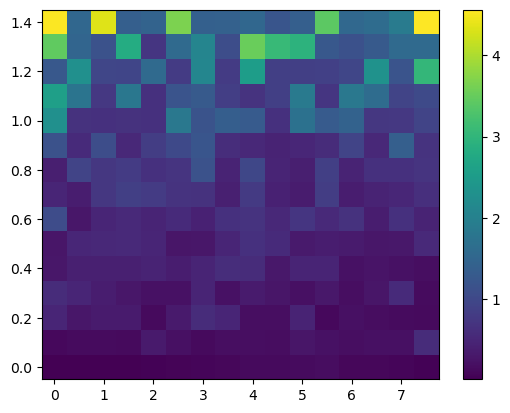

In [64]:
import matplotlib.pyplot as plt
import numpy as np

z = np.array(mae_list)
# Create a 2-D grid from the 1-D arrays
X, Y = np.meshgrid(V_list, beta_list)

# Define a function to plot
Z = z.reshape(Y.shape)

# Create a pseudocolor plot with a non-regular rectangular grid
plt.pcolormesh(X, Y, Z)
plt.colorbar() # Add a color bar to show the scale

# Show the plot
plt.show()

In [83]:
import numpy as np
from qutip import *
# Définition des paramétrés du systeme
N = 7 # Nombre de spin
Omega = 1 # Champ magnétique externe
gamma = 0.5 # Taux de decohérence
beta = 0.1 #Température du bain
# Définition des opérateurs de Paule
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1 + sigmaz())
id_ = tensor([qeye(2)]*(N-1))
# Définition des opérateurs de spin
sx_list = [tensor(id_, sx)]*N
sx_S = [tensor(sx, id_)]
sy_list = [tensor(id_, sy)]*N
sy_S = [tensor(sy, id_)]
sz_list = [tensor(id_, sz)]*N
sz_S = [tensor(sz, id_)]
n_list = [tensor(id_, n)]*N
n_S = [tensor(n, id_)]

# Définition du Hamiltonien
def H1D_CBC(omega, V, V_, delta):
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
    #Hamiltonien du systeme
    H_S = omega*sx_S[0] - delta*n_S[0] + V_*(n_S[0])*(n_list[0] + n_list[1])
    H = H_S + H_B
    return(H)

def H_bain(omega, V, delta):
    id_B = tensor([qeye(2)]*(N-2))
    sx_list = [tensor(id_B, sx)]*N
    sy_list = [tensor(id_B, sy)]*N
    sz_list = [tensor(id_B, sz)]*N
    n_list = [tensor(id_B, n)]*N
    #Hamiltonien du bain
    H_B = 0
    for i in range(N):
        if i ==  0:
            pass
        else:
            H_B += V*(n_list[i])*(n_list[(i+1)%N]) + omega*sx_list[i] - delta*n_list[i]
   
    return(H_B)

omega = 1
V = 10
V_ = 8
delta = 8
#print(H)

# Liste des operateurs de Lindblad
L = []
for i in range(N):
    L.append(np.sqrt(gamma)*(sx_list[i]))
hro0_S_list = [Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]]),
         Qobj([[1-np.random.uniform(0.01,0.7),0],[0,np.random.uniform(0.01,0.7)]])]
 
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error    
    

    
beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []
V_=4
# Etat initial du systeme
for beta in beta_list:
    for hro0_S in hro0_S_list:
        H = H1D_CBC(omega, V, V_, delta)
        H_B = H_bain(omega, V, delta)
        #hro_B = Qobj.expm(-beta*H_B)
        hro_B = (-beta*H_B).expm()
        #hro0 = tensor(hro0_S, qeye(2**(N-1)))

        hro0 = tensor(hro0_S, hro_B)
        #print('Etat initial:',hro0_S)

        # Donnees d'entrees
        tlistx = np.linspace(0, 1, 100)
        resultx = mesolve(H, hro0, tlistx, L, [sx_list[5], sy_list[5], sz_list[5]],args=None, options=None, progress_bar=None, _safe_mode=True)
        X0 = resultx.expect[0]
        X1 = resultx.expect[1] 
        X2 = resultx.expect[2]

        # Donnees de sortie
        tlisty = np.linspace(0+0.02, 1, 100)
        resulty = mesolve(H, hro0, tlisty, L, [sx_list[5], sy_list[5], sz_list[5]], args=None, options=None, progress_bar=None, _safe_mode=True)
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des sorties relle

        #Division de l'ensemble des donnees en donnees de formation et en donnees de test
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
        #print('mean square error:', mse)
        print('mean absolute error:', mae)

mean absolute error: 0.0063040061916552256
mean absolute error: 0.12891520831643505
mean absolute error: 0.1556847688424375
mean absolute error: 0.14427399206970726
mean absolute error: 0.07014596746413293
mean absolute error: 0.1616332198985781
mean absolute error: 0.1434234245158625
mean absolute error: 0.15256254616287235
mean absolute error: 0.2438333081800033
mean absolute error: 0.13946811761575467
mean absolute error: 0.6433176871800161
mean absolute error: 0.4851383545088504
mean absolute error: 0.24604850895598657
mean absolute error: 0.2779897180345603
mean absolute error: 0.16134466853139787
mean absolute error: 0.3050903745568701
mean absolute error: 0.31143571988104607
mean absolute error: 0.3793253074457574
mean absolute error: 0.4912150387593198
mean absolute error: 0.4846762379732328


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.15123171896296395
mean absolute error: 0.35565525975789264
mean absolute error: 0.5162785197394126


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.17569220961352514
mean absolute error: 0.42440050983271455
mean absolute error: 0.2376840289306173
mean absolute error: 0.21535428524021286
mean absolute error: 0.3834206993752476
mean absolute error: 0.2768135519233289
mean absolute error: 0.3858368137352402
mean absolute error: 0.45249829505330086
mean absolute error: 0.5338271008747487
mean absolute error: 0.55231672325301


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.22093190068531235
mean absolute error: 0.40725101325134894
mean absolute error: 0.2617313955368881
mean absolute error: 0.30845442029850006
mean absolute error: 0.4057081388221155


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.26627876123048755


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1846451173322878


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.1724743409545527
mean absolute error: 0.3077326142867892


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.20783839681113875
mean absolute error: 0.5750401421840677


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3153886377473477


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4148047193809422


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4298994301140934


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.30522006655591044


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2600087155909854


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.26739491798677295


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3283650489293412


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3508229576754998
mean absolute error: 0.6114198721042914


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.29937998325023074
mean absolute error: 0.6188798890088872


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3786230498911699


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3411367357955903


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3328553973834976


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.2876542850177394
mean absolute error: 0.6076900425488102
mean absolute error: 0.42999029828145
mean absolute error: 0.6584914265770987


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3712836246317987


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.44867136795113954


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3818983385896022


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5274314679059122


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.28295997954654173


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4024761926058017


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3886987175161277
mean absolute error: 0.5375829103889829


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.46487541265889404


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.45469318059056285


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.43226318748247067
mean absolute error: 1.0408026987689722
mean absolute error: 0.3755585679376155


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.43501809442268347


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.35385909192777387
mean absolute error: 0.6599467806181372


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4026056380495445
mean absolute error: 0.44217329968871333
mean absolute error: 0.7607984170165447
mean absolute error: 0.7188655707070735
mean absolute error: 0.4143241942795326
mean absolute error: 1.1571785988777865


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6390562343801839
mean absolute error: 0.5130400361497098


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.46602853998627947
mean absolute error: 1.2597975030359714
mean absolute error: 0.43953858512392474
mean absolute error: 1.1320350154086047
mean absolute error: 0.9589382836185658


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4415996097210735


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4694787045529144
mean absolute error: 0.5045658700661938


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5311374648007124


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5910816675520653


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5038169062594955


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6245887496364287
mean absolute error: 1.1338024409162426
mean absolute error: 0.4743605170115446
mean absolute error: 0.825944133269724
mean absolute error: 1.5066051416553419


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5147633450536044
mean absolute error: 1.4383183033393419


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6237934453833557


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6397404909383437


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7573655106418529
mean absolute error: 1.6215265588583438


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6254110678800247


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5650703812959283
mean absolute error: 1.6037936439547016


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8080789331871081


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6061197594588952


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7126196544108412
mean absolute error: 0.7722997240081844


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7866079198396813


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.7121142590719831
mean absolute error: 0.9139716386775099


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6665266689229559


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6898997132593788
mean absolute error: 0.83138219668412
mean absolute error: 2.597548618198824


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6221440698742833
mean absolute error: 0.9478855899623768
mean absolute error: 2.4278828103520405


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.0110093431295086
mean absolute error: 0.9008165648585167
mean absolute error: 1.0142571940858014


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9495811103008036


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9510398651441894


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8741683106080853


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9686409588848687


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8066012881955356
mean absolute error: 2.920097784811627


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1223312382766046


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.137169663434744
mean absolute error: 1.9307951236633905


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.133822064505472
mean absolute error: 3.027913927013877
mean absolute error: 3.532043629567375
mean absolute error: 1.1351769218044832
mean absolute error: 4.4281153610813035
mean absolute error: 1.2620716585306817


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3250533481152
mean absolute error: 1.5796529616239274


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7121367122420588


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.405611640714214


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5436531752280112
mean absolute error: 4.573806820439176
mean absolute error: 3.27314667302646


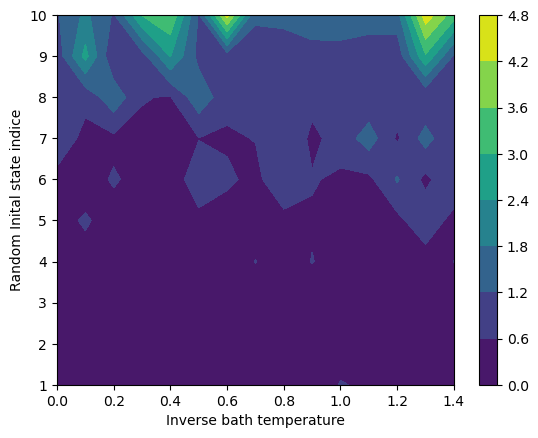

In [86]:
z = np.array(mae_list)
#print(mae_list)
X, Y = np.meshgrid(beta_list, [1,2,3,4,5,6,7,8,9,10])

Z = z.reshape(Y.shape)

fig = plt.figure()
ax1 = plt.contourf(X, Y, Z)
plt.colorbar(ax1)
plt.xlabel('Inverse bath temperature')
plt.ylabel('Random Inital state indice')
plt.show()

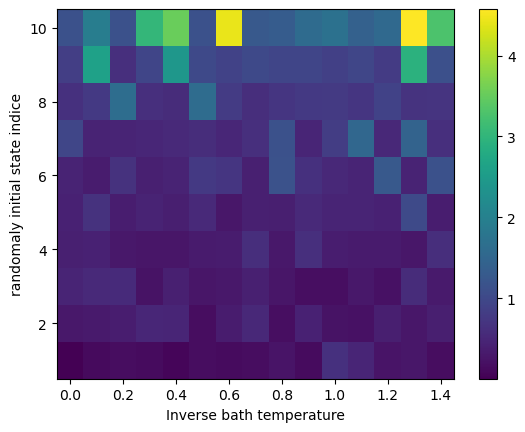

In [84]:
import matplotlib.pyplot as plt
import numpy as np

z = np.array(mae_list)
# Create a 2-D grid from the 1-D arrays
X, Y = np.meshgrid(beta_list, [1,2,3,4,5,6,7,8,9,10])

# Define a function to plot
Z = z.reshape(Y.shape)

# Create a pseudocolor plot with a non-regular rectangular grid
plt.pcolormesh(X, Y, Z)
plt.colorbar() # Add a color bar to show the scale
plt.ylabel('randomaly initial state indice')
plt.xlabel('Inverse bath temperature')

# Show the plot
plt.show()